In [1]:
import pandas as pd
import numpy as np
from itertools import chain
from tqdm import tqdm

In [2]:
from sensor_analysis_functions import fault_detection, plotting_anem_parameter_tunning, anemometer_identification, plot_sensors, get_index_list, split_kneighbor_indexes, generate_dashboard

ModuleNotFoundError: No module named 'tqdm'

In [3]:
df_vaquerias = pd.read_csv('../Cleaner/data/000960_Vaquerias,_Jalisco_meas_2017.09.04-2017.10.03.txt_data_cleaned.csv', index_col=0)
df_D161075 = pd.read_csv('../Cleaner/data/D161075_2016_data.csv', index_col=0)

In [4]:
#df_vaquerias_fault_detection = fault_detection(df_vaquerias, sensor='anem', correlation_window=10, ratio_th = 10, correlation_th= .7)
#df_vaquerias_anemometer_identification = anemometer_identification(df_vaquerias_fault_detection)

In [8]:
# Slice de las primeras 7 columnas para no agarrar las columnas con los min y std
df_D161075_fault_detection = fault_detection(df_D161075.iloc[:, :7], sensor='anem', correlation_window=3, ratio_th = 10, correlation_th= .5)
df_D161075_anemometer_identification = anemometer_identification(df_D161075_fault_detection)

100%|██████████| 2057/2057 [00:04<00:00, 507.13it/s]


In [9]:
df_D161075_redundant_sensors = {
    'Ch1Anem': 'Ch2Anem',
    'Ch2Anem': 'Ch1Anem',
    'Ch3Anem': 'Ch4Anem',
    'Ch4Anem': 'Ch3Anem',
    'Ch5Anem': 'Ch6Anem',
    'Ch6Anem': 'Ch5Anem',
}

In [11]:
df_D161075_anemometer_identification.name = 'D161075'
generate_dashboard(df_D161075_anemometer_identification, redundance_dict=df_D161075_redundant_sensors)

Already exists...


100%|██████████| 13/13 [00:00<00:00, 40.44it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [16]:
df_vaquerias_redundant_sensors = {
    'Ch1Anem': 'Ch2Anem',
    'Ch2Anem': 'Ch1Anem',
    'Ch3Anem': 'Ch2Anem',
    'Ch4Anem': 'Ch5Anem',
    'Ch5Anem': 'Ch4Anem',
    'Ch6Anem': 'Ch5Anem',
}

In [9]:
df_vaquerias_anemometer_identification.name = 'Vaquerias'
generate_dashboard(df_vaquerias_anemometer_identification, redundance_dict=df_vaquerias_redundant_sensors)

100%|██████████| 69/69 [00:05<00:00,  7.07it/s]


In [29]:
def anem_parameter_tunning(df, ch_anem, true_positive_list, ratio_range=30, correlation_range=10, correlation_window_range=10):
    
    df_to_tunning = df[df.columns[df.columns.str.contains('Anem')]].copy()

    idx = 0
    
    for ratio in range(2, ratio_range):
        for correlation in range(1, correlation_range):
            
            correlation = round(correlation *.1, 2)
            
            for window in range(1, correlation_window_range):
                
                df_fault_detection = fault_detection(df_to_tunning, sensor='anem', correlation_window=window, ratio_th=ratio, correlation_th=correlation)

                df_anem_filtered = anemometer_identification(df_fault_detection)

                indexes = get_index_list(df_anem_filtered, ch_anem)

                indexes_splitted = split_kneighbor_indexes(indexes, 12)
                
                
                n_true_positive = 0
                for index in indexes_splitted:
                    for true_positive in true_positive_list:
                        if any(i in true_positive for i in index):
                            n_true_positive += 1
                
                if n_true_positive >= len(true_positive_list) - 1:
                    print(f"Correlation: {correlation}\nCorrelation window: {window}\nRatio: {ratio}\nDetections: {len(split_kneighbor_indexes(indexes, 12))}\nTrue Positives: {n_true_positive}")

In [12]:
indexes = split_kneighbor_indexes(get_index_list(df_D161075_anemometer_identification, 'Ch1Anem'), 12)

In [13]:
print(indexes[0][0])

167


In [39]:
#df_D161075_fault_detection.loc[indexes[0][0]-10: indexes[0][0], 'Ch1Anem']
idx = 1

df_D161075_fault_detection.loc[indexes[idx][0]-3: indexes[idx][0], ['Ch1Anem','Ch2Anem', 'Timestamp']]#.plot()

,Ch1Anem,Ch2Anem,Timestamp
226,7.9644,8.0051,2016-09-16 03:20:00
227,7.9782,8.0326,2016-09-16 03:30:00
228,7.8391,7.8884,2016-09-16 03:40:00
229,8.0629,8.1198,2016-09-16 03:50:00


In [41]:
np.corrcoef(df_D161075_fault_detection.loc[indexes[idx][0]-3: indexes[idx][0], 'Ch1Anem'].values, df_D161075_fault_detection.loc[indexes[idx][0]-3: indexes[idx][0], 'Ch2Anem'].values)

array([[1.        , 0.99768784],
       [0.99768784, 1.        ]])

In [42]:
ch1_anom = df_D161075_fault_detection.loc[indexes[idx][0] - 3:indexes[idx][0], 'Ch1Anem'].copy()
ch2_anom = df_D161075_fault_detection.loc[indexes[idx][0] - 3:indexes[idx][0], 'Ch2Anem'].copy()

In [43]:
np.corrcoef(ch1_anom, ch2_anom)

array([[1.        , 0.99768784],
       [0.99768784, 1.        ]])

In [49]:
cols_ch1 = df_D161075_fault_detection.columns[df_D161075_fault_detection.columns.str.contains('Ch1Anem')]
df_D161075_fault_detection.loc[indexes[idx][0]: indexes[idx][0], cols_ch1]

,Ch1Anem,Ch1AnemVSCh2Anem_ratio*,Ch1AnemVSCh2Anem_ratio*_anomaly,Ch1AnemVSCh2Anem_correlation*,Ch1AnemVSCh2Anem_correlation*_anomaly,Ch1AnemVSCh3Anem_ratio*,Ch1AnemVSCh3Anem_ratio*_anomaly,Ch1AnemVSCh3Anem_correlation*,Ch1AnemVSCh3Anem_correlation*_anomaly,Ch1AnemVSCh4Anem_ratio*,Ch1AnemVSCh4Anem_ratio*_anomaly,Ch1AnemVSCh4Anem_correlation*,Ch1AnemVSCh4Anem_correlation*_anomaly,Ch1AnemVSCh5Anem_ratio*,Ch1AnemVSCh5Anem_ratio*_anomaly,Ch1AnemVSCh5Anem_correlation*,Ch1AnemVSCh5Anem_correlation*_anomaly,Ch1AnemVSCh6Anem_ratio*,Ch1AnemVSCh6Anem_ratio*_anomaly,Ch1AnemVSCh6Anem_correlation*,Ch1AnemVSCh6Anem_correlation*_anomaly
229,8.0629,0.992992,0,0.997688,0,1.042109,0,-0.031252,1,1.03254,0,-0.033701,1,1.17499,0,-0.299379,1,1.165782,0,-0.288288,1


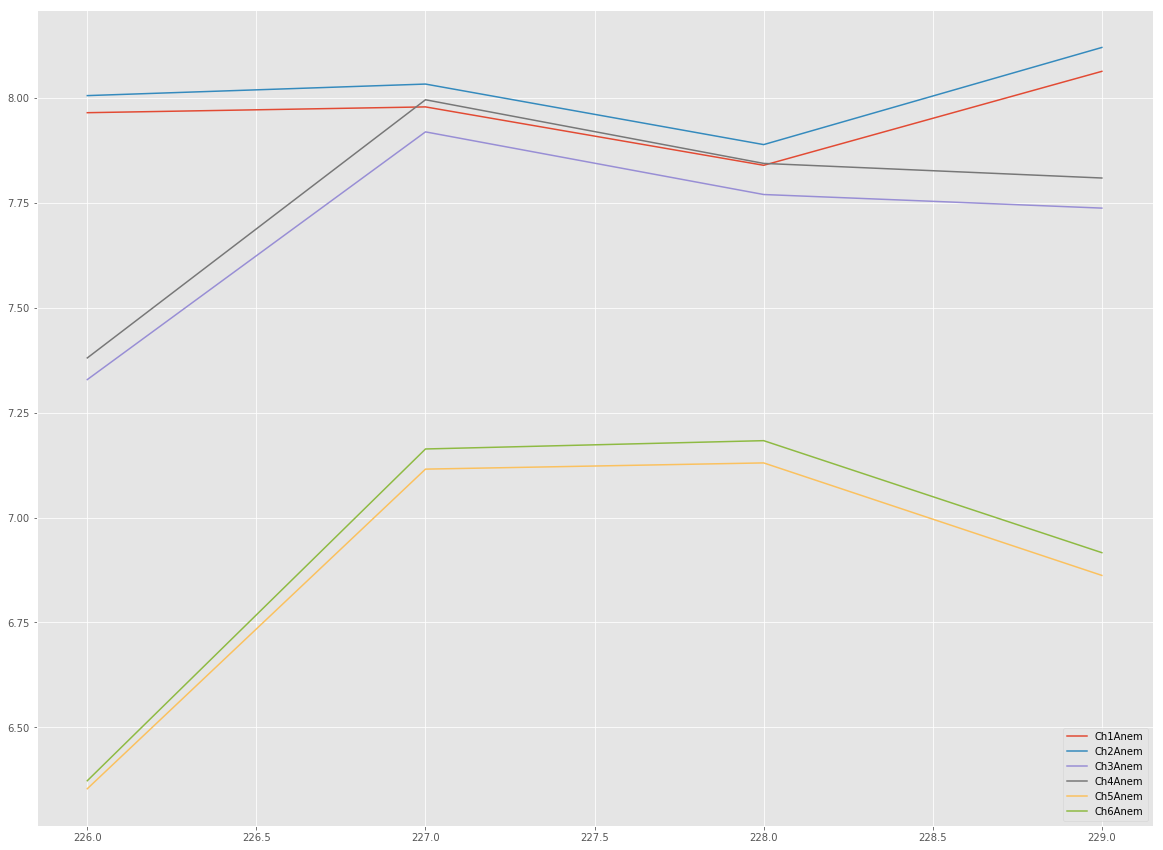

In [57]:
df_D161075_fault_detection.loc[indexes[idx][0]-3: indexes[idx][0], ['Ch1Anem', 'Ch2Anem', 'Ch3Anem', 'Ch4Anem', 'Ch5Anem', 'Ch6Anem']].plot(figsize=(20,15))

In [25]:
true_positive_list = [indexes[1], indexes[6], indexes[7], indexes[9], indexes[10], indexes[13], indexes[18]]

In [32]:
len(true_positive_list)

7

In [30]:
anem_parameter_tunning(df_D161075, 'Ch1Anem', true_positive_list, ratio_range=9, correlation_range=11, correlation_window_range=11)

100%|██████████| 103/103 [00:00<00:00, 552.17it/s]
D:\Program Files (x86)\Anaconda\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike

100%|██████████| 3178/3178 [00:05<00:00, 577.55it/s]


Correlation: 0.1
Correlation window: 2
Ratio: 2
Detections: 60
True Positives: 7


100%|██████████| 1801/1801 [00:02<00:00, 616.03it/s]


Correlation: 0.1
Correlation window: 3
Ratio: 2
Detections: 21
True Positives: 6


100%|██████████| 3178/3178 [00:05<00:00, 549.96it/s]


Correlation: 0.2
Correlation window: 2
Ratio: 2
Detections: 60
True Positives: 7


100%|██████████| 1949/1949 [00:03<00:00, 590.93it/s]


Correlation: 0.2
Correlation window: 3
Ratio: 2
Detections: 23
True Positives: 6


100%|██████████| 3178/3178 [00:05<00:00, 556.98it/s]


Correlation: 0.3
Correlation window: 2
Ratio: 2
Detections: 60
True Positives: 7


100%|██████████| 2136/2136 [00:03<00:00, 573.63it/s]


Correlation: 0.3
Correlation window: 3
Ratio: 2
Detections: 25
True Positives: 6


100%|██████████| 3178/3178 [00:05<00:00, 563.17it/s]


Correlation: 0.4
Correlation window: 2
Ratio: 2
Detections: 60
True Positives: 7


100%|██████████| 2325/2325 [00:03<00:00, 591.03it/s]


Correlation: 0.4
Correlation window: 3
Ratio: 2
Detections: 30
True Positives: 6


100%|██████████| 1299/1299 [00:02<00:00, 608.79it/s]


Correlation: 0.4
Correlation window: 7
Ratio: 2
Detections: 23
True Positives: 7


100%|██████████| 1222/1222 [00:01<00:00, 623.29it/s]


Correlation: 0.4
Correlation window: 8
Ratio: 2
Detections: 19
True Positives: 6


100%|██████████| 3178/3178 [00:05<00:00, 568.98it/s]


Correlation: 0.5
Correlation window: 2
Ratio: 2
Detections: 60
True Positives: 7


100%|██████████| 2570/2570 [00:04<00:00, 591.87it/s]


Correlation: 0.5
Correlation window: 3
Ratio: 2
Detections: 36
True Positives: 7


100%|██████████| 2107/2107 [00:03<00:00, 592.44it/s]


Correlation: 0.5
Correlation window: 4
Ratio: 2
Detections: 33
True Positives: 6


100%|██████████| 1856/1856 [00:03<00:00, 596.66it/s]


Correlation: 0.5
Correlation window: 5
Ratio: 2
Detections: 33
True Positives: 6


100%|██████████| 1685/1685 [00:02<00:00, 592.32it/s]


Correlation: 0.5
Correlation window: 6
Ratio: 2
Detections: 29
True Positives: 6


100%|██████████| 1573/1573 [00:02<00:00, 606.67it/s]


Correlation: 0.5
Correlation window: 7
Ratio: 2
Detections: 30
True Positives: 7


100%|██████████| 1502/1502 [00:02<00:00, 604.36it/s]


Correlation: 0.5
Correlation window: 8
Ratio: 2
Detections: 27
True Positives: 7


100%|██████████| 1458/1458 [00:02<00:00, 607.97it/s]


Correlation: 0.5
Correlation window: 9
Ratio: 2
Detections: 28
True Positives: 7


100%|██████████| 1428/1428 [00:02<00:00, 615.70it/s]


Correlation: 0.5
Correlation window: 10
Ratio: 2
Detections: 24
True Positives: 6


100%|██████████| 3178/3178 [00:05<00:00, 572.55it/s]


Correlation: 0.6
Correlation window: 2
Ratio: 2
Detections: 60
True Positives: 7


100%|██████████| 2938/2938 [00:05<00:00, 576.96it/s]


Correlation: 0.6
Correlation window: 3
Ratio: 2
Detections: 44
True Positives: 8


100%|██████████| 2490/2490 [00:04<00:00, 591.61it/s]


Correlation: 0.6
Correlation window: 4
Ratio: 2
Detections: 41
True Positives: 7


100%|██████████| 2230/2230 [00:03<00:00, 598.11it/s]


Correlation: 0.6
Correlation window: 5
Ratio: 2
Detections: 41
True Positives: 9


100%|██████████| 2053/2053 [00:03<00:00, 577.34it/s]


Correlation: 0.6
Correlation window: 6
Ratio: 2
Detections: 38
True Positives: 8


100%|██████████| 1951/1951 [00:03<00:00, 608.23it/s]


Correlation: 0.6
Correlation window: 7
Ratio: 2
Detections: 38
True Positives: 9


100%|██████████| 1889/1889 [00:03<00:00, 605.71it/s]


Correlation: 0.6
Correlation window: 8
Ratio: 2
Detections: 35
True Positives: 8


100%|██████████| 1829/1829 [00:03<00:00, 581.03it/s]


Correlation: 0.6
Correlation window: 9
Ratio: 2
Detections: 36
True Positives: 8


100%|██████████| 1770/1770 [00:02<00:00, 615.39it/s]


Correlation: 0.6
Correlation window: 10
Ratio: 2
Detections: 34
True Positives: 8


100%|██████████| 3178/3178 [00:05<00:00, 574.03it/s]


Correlation: 0.7
Correlation window: 2
Ratio: 2
Detections: 60
True Positives: 7


100%|██████████| 3432/3432 [00:05<00:00, 572.26it/s]


Correlation: 0.7
Correlation window: 3
Ratio: 2
Detections: 58
True Positives: 9


100%|██████████| 3071/3071 [00:05<00:00, 597.82it/s]


Correlation: 0.7
Correlation window: 4
Ratio: 2
Detections: 53
True Positives: 9


100%|██████████| 2795/2795 [00:04<00:00, 569.42it/s]


Correlation: 0.7
Correlation window: 5
Ratio: 2
Detections: 49
True Positives: 11


100%|██████████| 2602/2602 [00:04<00:00, 570.40it/s]


Correlation: 0.7
Correlation window: 6
Ratio: 2
Detections: 46
True Positives: 9


100%|██████████| 2527/2527 [00:04<00:00, 597.69it/s]


Correlation: 0.7
Correlation window: 7
Ratio: 2
Detections: 45
True Positives: 10


100%|██████████| 2423/2423 [00:04<00:00, 596.11it/s]


Correlation: 0.7
Correlation window: 8
Ratio: 2
Detections: 42
True Positives: 10


100%|██████████| 2304/2304 [00:03<00:00, 597.66it/s]


Correlation: 0.7
Correlation window: 9
Ratio: 2
Detections: 40
True Positives: 9


100%|██████████| 2246/2246 [00:03<00:00, 589.66it/s]


Correlation: 0.7
Correlation window: 10
Ratio: 2
Detections: 41
True Positives: 11


100%|██████████| 3178/3178 [00:05<00:00, 560.12it/s]


Correlation: 0.8
Correlation window: 2
Ratio: 2
Detections: 60
True Positives: 7


100%|██████████| 4272/4272 [00:07<00:00, 574.23it/s]


Correlation: 0.8
Correlation window: 3
Ratio: 2
Detections: 86
True Positives: 12


100%|██████████| 3995/3995 [00:07<00:00, 564.88it/s]


Correlation: 0.8
Correlation window: 4
Ratio: 2
Detections: 81
True Positives: 17


100%|██████████| 3746/3746 [00:07<00:00, 527.25it/s]


Correlation: 0.8
Correlation window: 5
Ratio: 2
Detections: 74
True Positives: 19


100%|██████████| 3545/3545 [00:07<00:00, 491.94it/s]


Correlation: 0.8
Correlation window: 6
Ratio: 2
Detections: 68
True Positives: 17


100%|██████████| 3367/3367 [00:06<00:00, 501.73it/s]


Correlation: 0.8
Correlation window: 7
Ratio: 2
Detections: 65
True Positives: 16


100%|██████████| 3258/3258 [00:06<00:00, 523.25it/s]


Correlation: 0.8
Correlation window: 8
Ratio: 2
Detections: 64
True Positives: 15


100%|██████████| 3185/3185 [00:05<00:00, 531.33it/s]


Correlation: 0.8
Correlation window: 9
Ratio: 2
Detections: 59
True Positives: 13


100%|██████████| 3107/3107 [00:05<00:00, 550.01it/s]


Correlation: 0.8
Correlation window: 10
Ratio: 2
Detections: 52
True Positives: 13


100%|██████████| 3178/3178 [00:06<00:00, 510.35it/s]


Correlation: 0.9
Correlation window: 2
Ratio: 2
Detections: 60
True Positives: 7


100%|██████████| 6009/6009 [00:12<00:00, 498.77it/s]


Correlation: 0.9
Correlation window: 3
Ratio: 2
Detections: 122
True Positives: 15


100%|██████████| 6052/6052 [00:11<00:00, 531.05it/s]


Correlation: 0.9
Correlation window: 4
Ratio: 2
Detections: 124
True Positives: 18


100%|██████████| 5861/5861 [00:11<00:00, 532.40it/s]


Correlation: 0.9
Correlation window: 5
Ratio: 2
Detections: 118
True Positives: 20


100%|██████████| 5653/5653 [00:10<00:00, 543.05it/s]


Correlation: 0.9
Correlation window: 6
Ratio: 2
Detections: 117
True Positives: 21


 16%|█▌        | 877/5443 [00:01<00:08, 556.28it/s]


KeyboardInterrupt: 